<a href="https://colab.research.google.com/github/ayrna/ap2122/blob/main/redes_recurrentes/LSTM_IMDB_Sentiment_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ¿Qué es esto?

Este cuaderno de Jupyter contiene código Python para construir una red recurrente LSTM  que proporciona alrededor de un 87-88% de precisión en el dataset *IMDB Movie Review Sentiment Analysis Dataset*. 

Para más información podéis consultar este [enlace](https://www.bouvet.no/bouvet-deler/explaining-recurrent-neural-networks).

## Pensado para Google Collaboratory

El código está preparado para funcionar en Google Collab. Si queréis ejecutarlo de forma local, tendréis que configurar todos los elementos (Cuda, Tensorflow...).

En Google Collab, para conseguir que la red se entrene más rápido deberíamos usar la GPU. En el menú **Entorno de ejecución** elige **Cambiar tipo de entorno de ejecución** y selecciona "GPU".

No olvides hacer los cambios efectivos pulsando sobre **Reiniciar entorno de ejecución**.


## Preparándolo todo

Al ejecutar este código, puede ser que recibas un *warning* pidiéndote que reinicies el *Entorno de ejecución*. Puedes ignorarlo o reiniciarlo con "Entorno de ejecución -> Reiniciar entorno de ejecución" si encuentras algún tipo de problema.

In [1]:
# Todos los import necesarios
import tensorflow as tf 
import numpy as np
from tensorflow.keras.preprocessing import sequence
from numpy import array

# Suprimir los warning de tensorflow
import logging
logging.getLogger('tensorflow').disabled = True

# Obtener los datos de "IMDB Movie Review", limitando las revisiones
# a las 10000 palabras más comunes
vocab_size = 10000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)

# Maping de las etiquetas
class_names = ["Negative", "Positive"]

## Crear un mapeo que nos permita convertir el dataset IMDB a revisiones que podamos leer

Las revisiones en el dataset IMDB están codificadas como una secuencia de enteros. Afortunadamente, el dataset también contiene un índice que nos permite volver a una representación tipo texto.

In [2]:
# Obtener el índice de palabras del dataset
word_index = tf.keras.datasets.imdb.get_word_index()

# Asegurarnos de que las palabras "especiales" pueden leerse correctamente 
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2
word_index["<UNUSED>"] = 3

# Buscar las palabras en el índice y hacer una función que decodifique cada review
# Si la palabra no está devolverá '?'
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

## Echemos un vistazo a los datos

Ahora vamos a ver más de cerca los datos. ¿Cuántas palabras contienen nuestras reviews?

¿Qué aspecto tiene una review codificada y decodificada?


In [3]:
# Concatenar los datasets de entrenamiento y de test
allreviews = np.concatenate((x_train, x_test), axis=0)

# Longitud de las revisiones a largo de los dos conjuntos
result = [len(x) for x in allreviews]
print("Máxima longitud de una revisión: {}".format(np.max(result)))
print("Mínima longitud de una revisión: {}".format(np.min(result)))
print("Longitud media de las revisiones: {}".format(np.mean(result)))

# Imprimir una revisión concreta y su etiqueta.
# Reemplaza el número si quieres ver otra.
review_to_print=60
print("")
print("Revisión en modo máquina (codificada)")
print("  Código de la revisión: " + str(x_train[review_to_print]))
print("  Sentimiento: " + str(y_train[review_to_print]))
print("")
print("Revisión en modo texto")
print("  Texto de la revisión: " + decode_review(x_train[review_to_print]))
print("  Sentimiento: " + class_names[y_train[review_to_print]])


Máxima longitud de una revisión: 2494
Mínima longitud de una revisión: 7
Longitud media de las revisiones: 234.75892

Revisión en modo máquina (codificada)
  Código de la revisión: [1, 13, 219, 14, 33, 4, 2, 22, 1413, 12, 16, 373, 175, 2711, 1115, 1026, 430, 939, 16, 23, 2444, 25, 43, 697, 89, 12, 16, 170, 8, 130, 262, 19, 32, 4, 665, 7, 4, 2, 322, 5, 4, 1520, 7, 4, 86, 250, 10, 10, 4, 249, 173, 16, 4, 3891, 6, 19, 4, 167, 564, 5, 564, 1325, 36, 805, 8, 216, 638, 17, 2, 21, 25, 100, 376, 507, 4, 2110, 15, 79, 125, 23, 567, 13, 2134, 233, 36, 4852, 2, 5, 81, 1672, 10, 10, 92, 437, 129, 58, 13, 69, 8, 401, 61, 1432, 39, 1286, 46, 7, 12]
  Sentimiento: 0

Revisión en modo texto
  Texto de la revisión: <START> i saw this at the <UNKNOWN> film festival it was awful every clichéd violent rich boy fantasy was on display you just knew how it was going to end especially with all the shots of the <UNKNOWN> wife and the rape of the first girl br br the worst part was the q a with the director wri

## Pre-procesando los datos

Tenemos que asegurarnos de que nuestras revisiones tienen siempre la misma
longitud, ya que se necesita para establecer los parámetros de la LSTM.

Para algunas revisiones tendremos que truncar algunas palabras, mientras que para otras habrá que establecer palabras de relleno (`padding`).

In [4]:
# Longitud a la que vamos a dejar la ventana
review_length = 500

# Truncar o rellenar los conjuntos
x_train = sequence.pad_sequences(x_train, maxlen = review_length)
x_test = sequence.pad_sequences(x_test, maxlen = review_length)

# Comprobamos el tamaño de los conjuntos. Revisaremos los datos de entrenamiento
# y de test, comprobando que las 25000 revisiones tienen 500 enteros.
# Las etiquetas de clase deberían ser 25000, con valores de 0 o 1
print("Shape de los datos de entrenamiento: " + str(x_train.shape))
print("Shape de la etiqueta de entrenamiento " + str(y_train.shape))
print("Shape de los datos de test: " + str(x_test.shape))
print("Shape de la etiqueta de test: " + str(y_test.shape))

# Note padding is added to start of review, not the end
print("")
print("Texto de la revisión (post padding): " + decode_review(x_train[60]))

Shape de los datos de entrenamiento: (25000, 500)
Shape de la etiqueta de entrenamiento (25000,)
Shape de los datos de test: (25000, 500)
Shape de la etiqueta de test: (25000,)

Texto de la revisión (post padding): <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

## Crear y construir una red LSTM recurrente

In [5]:
# Empezamos definiendo una pila vacía. Usaremos esta pila para ir construyendo
# la red, capa por capa
model = tf.keras.models.Sequential()

# La capa de tipo Embedding proporciona un mapeo (también llamado Word Embedding)
# para todas las palabras de nuestro conjunto de entrenamiento. En este embedding,
# las palabras que están cerca unas de otras comparten información de contexto 
# y/o de significado. Esta transformación es aprendida durante el entrenamiento
model.add(
    tf.keras.layers.Embedding(
        input_dim = vocab_size, # Tamaño del vocabulario
        output_dim = 32, # Dimensionalidad del embedding
        input_length = review_length # Longitud de las secuencias de entrada
    )
)

# Las capas de tipo Dropout combaten el sobre aprendizaje y fuerzan a que el 
# modelo aprenda múltiples representaciones de los mismos datos, ya que pone a 
# cero de forma aleatoria algunas de las neuronas durante la fase de 
# entrenamiento
model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Poner a cero aleatoriamente un 25% de las neuronas
    )
)

# Aquí es donde viene realmente la capa LSTM. Esta capa va a mirar cada 
# secuencia de palabras de la revisión junto con sus embeddings y utilizará 
# ambos elementos para determinar el sentimiento de la revisión
model.add(
    tf.keras.layers.LSTM(
        units=32 # La capa va a tener 32 neuronas de tipo LSTM
    )
)

# Añadir una segunda capa Dropout con el mismo objetivo que la primera
model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Poner a cero aleatoriamente un 25% de las neuronas
    )
)

# Todas las neuronas LSTM se conectan a un solo nodo en la capa densa. La 
# función sigmoide determina la salida de este nodo, con un valor entre 0 y 1.
# Cuanto más cercano sea a 1, más positiva es la revisión
model.add(
    tf.keras.layers.Dense(
        units=1, # Una única salida
        activation='sigmoid' # Función de activación sigmoide
    )
)

# Compilar el modelo
model.compile(
    loss=tf.keras.losses.binary_crossentropy, # Entropía cruzada
    optimizer=tf.keras.optimizers.Adam(), # Optimizador Adam
    metrics=['accuracy']) # Métrica de los informes

# Mostrar un resumen de la estructura del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 dropout (Dropout)           (None, 500, 32)           0         
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


## Visualizar el modelo

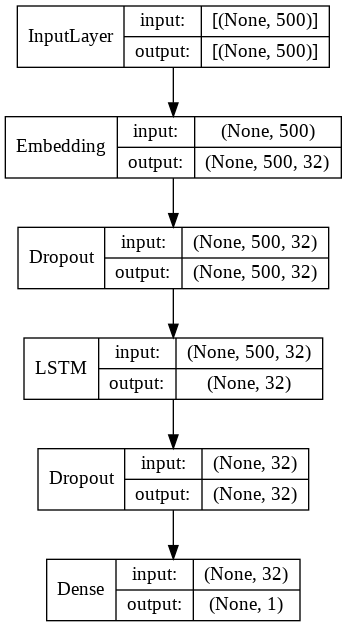

In [6]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

## Entrenar la LSTM

In [7]:
# Entrenar la LSTM en los datos de entrenamiento
history = model.fit(

    # Datos de entrenamiento : características (revisiones) y clases (positivas o negativas)
    x_train, y_train,
                    
    # Número de ejemplos a examinar antes de actualizar los pesos en el 
    # backpropagation. Cuanto más grande sea el tamaño de batch, más memoria
    # necesitaremos
    batch_size=256, 

    # Una época hace tantos batches como sea necesario para agotar el conjunto
    # de entrenamiento
    epochs=3, 
    
    # Esta fracción de los datos será usada como conjunto de validación, con 
    # vistas a detener el algoritmo si se está produciendo sobre aprendizaje
    validation_split=0.2,
    
    verbose=1
) 

Epoch 1/3
79/79 [==============================] - 14s 93ms/step - loss: 0.6087 - accuracy: 0.6690 - val_loss: 0.4179 - val_accuracy: 0.8342
Epoch 2/3
79/79 [==============================] - 6s 73ms/step - loss: 0.3091 - accuracy: 0.8798 - val_loss: 0.3004 - val_accuracy: 0.8778
Epoch 3/3
79/79 [==============================] - 6s 70ms/step - loss: 0.2110 - accuracy: 0.9232 - val_loss: 0.3035 - val_accuracy: 0.8852


## Evaluar el modelo con los datos de test y ver el resultado

In [8]:
# Obtener las predicciones para los datos de test
from sklearn.metrics import classification_report
predicted_probabilities = model.predict(x_test)
predicted_classes = predicted_probabilities  > 0.5
print(classification_report(y_test, predicted_classes, target_names=class_names))
tf.math.confusion_matrix(y_test, predicted_classes)

              precision    recall  f1-score   support

    Negative       0.85      0.91      0.88     12500
    Positive       0.90      0.84      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.88      0.87      0.87     25000
weighted avg       0.88      0.87      0.87     25000



<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[11380,  1120],
       [ 2048, 10452]], dtype=int32)>

## Ver algunas predicciones incorrectas

Vamos a echar un vistazo a algunas de las revisiones incorrectamente clasificadas. Eliminaremos el `padding`.



In [9]:
predicted_classes_reshaped = np.reshape(predicted_classes, 25000)

incorrect = np.nonzero(predicted_classes_reshaped!=y_test)[0]

# Nos vamos a centrar en las 20 primeras revisiones incorrectas
for j, incorrect in enumerate(incorrect[0:20]):
    
    predicted = class_names[predicted_classes_reshaped[incorrect].astype(int)]
    actual = class_names[y_test[incorrect]]
    human_readable_review = decode_review(x_test[incorrect])
    
    print("Revisión de test incorrectamente clasificada ["+ str(j+1) +"]") 
    print("Revisión de test #" + str(incorrect)  + ": Predicho ["+ predicted + "] Objetivo ["+ actual + "]")
    print("Texto de la revisión: " + human_readable_review.replace("<PAD> ", ""))
    print("")

Revisión de test incorrectamente clasificada [1]
Revisión de test #2: Predicho [Negative] Objetivo [Positive]
Texto de la revisión: at a time when motion picture animation of all sorts was in its <UNKNOWN> br br the political <UNKNOWN> of the russian revolution caused <UNKNOWN> to move to paris where one of his first productions <UNKNOWN> was a dark political satire <UNKNOWN> known as <UNKNOWN> or the <UNKNOWN> who wanted a king a strain of black comedy can be found in almost all of films but here it is very dark indeed aimed more at grown ups who can appreciate the satirical aspects than children who would most likely find the climax <UNKNOWN> i'm middle aged and found it pretty <UNKNOWN> myself and indeed <UNKNOWN> of the film intended for english speaking viewers of the 1920s were given title cards filled with <UNKNOWN> and <UNKNOWN> in order to help <UNKNOWN> the sharp <UNKNOWN> of the finale br br our tale is set in a swamp the <UNKNOWN> <UNKNOWN> where the citizens are unhappy wi

## Prueba tu propio texto como conjunto de test

Esta es una forma divertida de comprobar los límites del modelo que hemos entrenado. Debes teclear todo en minúscula y no usar signos de puntuación.

Podrás comprobar la predicción del modelo, un valor entre 0 y 1


In [10]:
# Escribe tu propia revisión (EN INGLÉS)
#review = "this was a terrible film with too much sex and violence i walked out halfway through"
review = "this is the best film i have ever seen it is great and fantastic and i loved it"
#review = "this was an awful film that i will never see again"
#review = "absolutely wonderful movie i am sure i will repeat it really worth the money i am delighted with the actors and i think it is epic the best movie from this director it is really fantastic and super"

# Codificamos la revisión (reemplazamos las palabras por los enteros)
tmp = []
for word in review.split(" "):
    tmp.append(word_index[word])

# Nos aseguramos que la longitud de secuencia es 500
tmp_padded = sequence.pad_sequences([tmp], maxlen=review_length) 

# Introducimos la revisión ya procesada en el modelo
rawprediction = model.predict(array([tmp_padded][0]))[0][0]
prediction = int(round(rawprediction))

# Probamos el modelo y vemos los resultados
print("Revisión: " + review)
print("Predicción numérica: " + str(rawprediction))
print("Clase predicha: " + class_names[prediction])

Revisión: this is the best film i have ever seen it is great and fantastic and i loved it
Predicción numérica: 0.96299314
Clase predicha: Positive


## Redes GRU

Ahora vamos a repetir el entrenamiento pero con las redes GRU. Recuerda que las redes Gated Recurrent Unit (GRU) implementan una simplificación de la neurona LSTM basada en reducir el número de puertas, parámetros y estaddos de la misma.

In [11]:
# Pila vacía
model = tf.keras.models.Sequential()

# Embedding
model.add(
    tf.keras.layers.Embedding(
        input_dim = vocab_size, # Tamaño del vocabulario
        output_dim = 32, # Dimensionalidad del embedding
        input_length = review_length # Longitud de las secuencias de entrada
    )
)

# Primer Dropout
model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Poner a cero aleatoriamente un 25% de las neuronas
    )
)

# Capa GRU
model.add(
    tf.keras.layers.GRU(
        units=32 # La capa va a tener 32 neuronas de tipo LSTM
    )
)

# Segundo Dropout
model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Poner a cero aleatoriamente un 25% de las neuronas
    )
)

# Capa densa final
model.add(
    tf.keras.layers.Dense(
        units=1, # Una única salida
        activation='sigmoid' # Función de activación sigmoide
    )
)

# Compilar el modelo
model.compile(
    loss=tf.keras.losses.binary_crossentropy, # Entropía cruzada
    optimizer=tf.keras.optimizers.Adam(), # Optimizador Adam
    metrics=['accuracy']) # Métrica de los informes

# Mostrar un resumen de la estructura del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 32)           320000    
                                                                 
 dropout_2 (Dropout)         (None, 500, 32)           0         
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 326,369
Trainable params: 326,369
Non-trainable params: 0
_________________________________________________________________


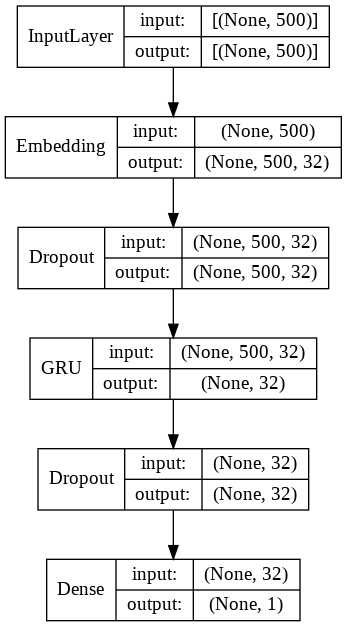

In [12]:
# Representar el modelo
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [13]:
# Entrenar la GRU en los datos
history = model.fit(

    # Datos de entrenamiento
    x_train, y_train,
                    
    # Tamaño de batch
    batch_size=256, 

    # Número de épocas
    epochs=3, 
    
    # Porcentaje de validación
    validation_split=0.2,
    
    verbose=1
) 

Epoch 1/3
79/79 [==============================] - 10s 98ms/step - loss: 0.6520 - accuracy: 0.6093 - val_loss: 0.4745 - val_accuracy: 0.7818
Epoch 2/3
79/79 [==============================] - 6s 82ms/step - loss: 0.3619 - accuracy: 0.8442 - val_loss: 0.3369 - val_accuracy: 0.8568
Epoch 3/3
79/79 [==============================] - 6s 80ms/step - loss: 0.2425 - accuracy: 0.9078 - val_loss: 0.3124 - val_accuracy: 0.8768


In [14]:
# Obtener las predicciones para los datos de test
from sklearn.metrics import classification_report

predicted_probabilities = model.predict(x_test)
predicted_classes = predicted_probabilities  > 0.5
print(classification_report(y_test, predicted_classes, target_names=class_names))
tf.math.confusion_matrix(y_test, predicted_classes)

              precision    recall  f1-score   support

    Negative       0.89      0.84      0.87     12500
    Positive       0.85      0.90      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[10551,  1949],
       [ 1277, 11223]], dtype=int32)>

## Referencia

Este material ha sido elaborado a partir del [cuaderno](https://github.com/markwest1972/LSTM-Example-Google-Colaboratory) de Mark West